# Build an *ARMA* Predictive Time Series Model for Larcenies (WIP)
 _ this is a work in progress and needs further elaboration to be solid _

import python modules

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime
import statsmodels.api as sm
from math import sqrt
import seaborn as sns

In [27]:
%matplotlib inline

set figure size

In [28]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)

set seaborn style

In [83]:
sns.set_style("whitegrid")

# Load the data

In [30]:
# s is our raw series of observations
s = pd.read_pickle('lar_series.pkl')

In [31]:
X = s.resample('M').count()

In [32]:
X.describe()

count    161.000000
mean     171.782609
std       41.954394
min       26.000000
25%      149.000000
50%      166.000000
75%      198.000000
max      286.000000
Name: offense_short_description, dtype: float64

In [33]:
X.head()

incident_dt
2005-01-31    173
2005-02-28    157
2005-03-31    157
2005-04-30    182
2005-05-31    189
Freq: M, Name: offense_short_description, dtype: int64

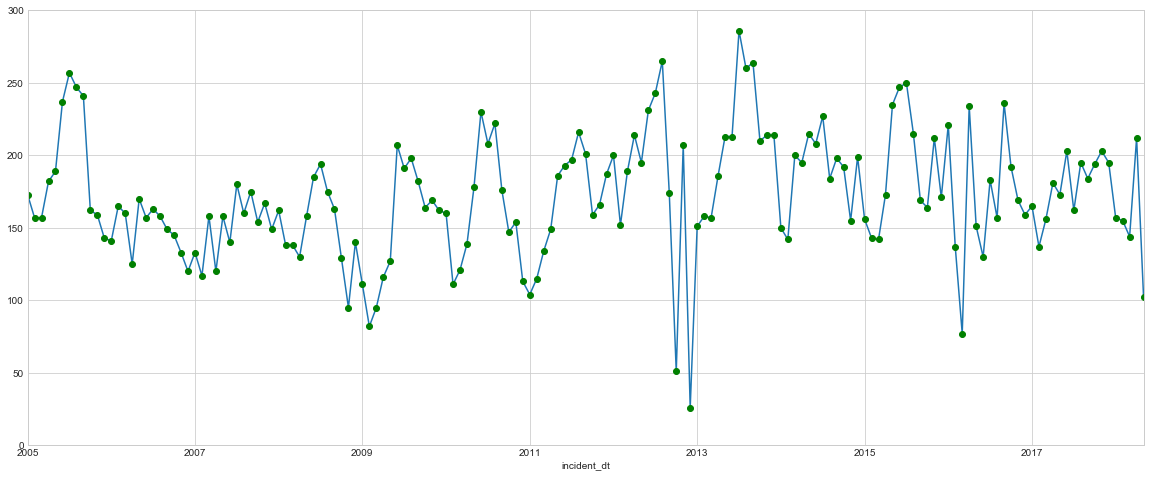

In [84]:
plt.ylim(0, 300)
X.plot()
X.plot(style='go', grid=True)

# Modeling the data with a time series analysis

lets build an ARMA model

http://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html

lets look at the ACF and PACF for signs of seasonality

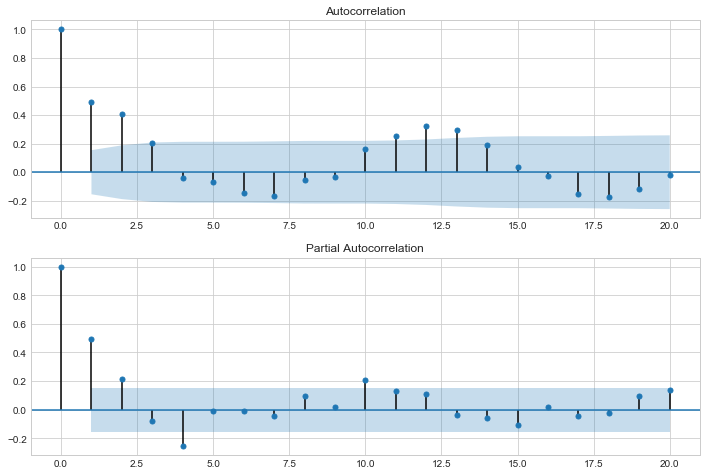

In [88]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X, lags=20, ax=ax2)

*Looks like a seasonal effect right around 12 months*

http://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html

statsmodels documentation suggests fitting an AR model to find the right lag 

In [89]:
model = sm.tsa.AR(X)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
# print('Coefficients: %s' % model_fit.params)

Lag: 14


In [91]:
# see this dicussion 
# https://github.com/statsmodels/statsmodels/issues/3247
X1 = X.astype(float)

A lag of 14 months is our "magic" number. But 12 months makes more sense based on the domain

In [200]:
# arma_mod1 = sm.tsa.ARMA(X, (14,1)).fit(disp=False)
arma = sm.tsa.ARMA(X1, (14, 1)).fit(disp=False, trend='c')

In [198]:
arima = sm.tsa.ARIMA(X1, (14, 0, 1)).fit(disp=False, trend='c')

In [201]:
print(arma.aic, arma.bic, arma.hqic)
print(arima.aic, arima.bic, arima.hqic)

(1611.334714188825, 1663.7185883935608, 1632.6046950771245)
(1611.334714188825, 1663.7185883935608, 1632.6046950771245)


In [181]:
best = arima

In [182]:
predicted = best.predict(150, 160, dynamic=True)
actual = X[150:160]
compare = pd.DataFrame(actual)
compare.columns = ['actual']
compare['predicted'] = predicted
compare['difference'] = compare['actual'] - compare['predicted']
compare['percent error'] = (compare['difference']/compare['actual']) * 100.
print(compare)

             actual   predicted  difference  percent error
incident_dt                                               
2017-07-31      162  192.638024  -30.638024     -18.912361
2017-08-31      195  195.680378   -0.680378      -0.348912
2017-09-30      184  204.457644  -20.457644     -11.118285
2017-10-31      194  188.604520    5.395480       2.781175
2017-11-30      203  181.257167   21.742833      10.710755
2017-12-31      195  170.480630   24.519370      12.574036
2018-01-31      157  158.407862   -1.407862      -0.896728
2018-02-28      155  159.543361   -4.543361      -2.931201
2018-03-31      144  157.871666  -13.871666      -9.633101
2018-04-30      212  167.977774   44.022226      20.765201


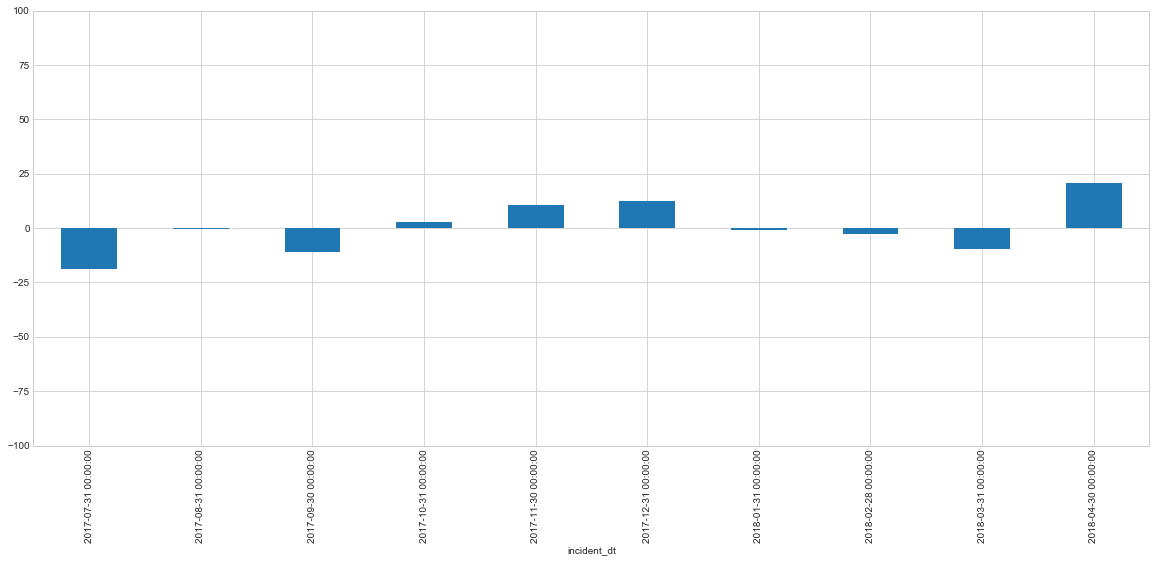

In [183]:
plt.ylim(-100,100)
compare['percent error'].plot(kind='bar')

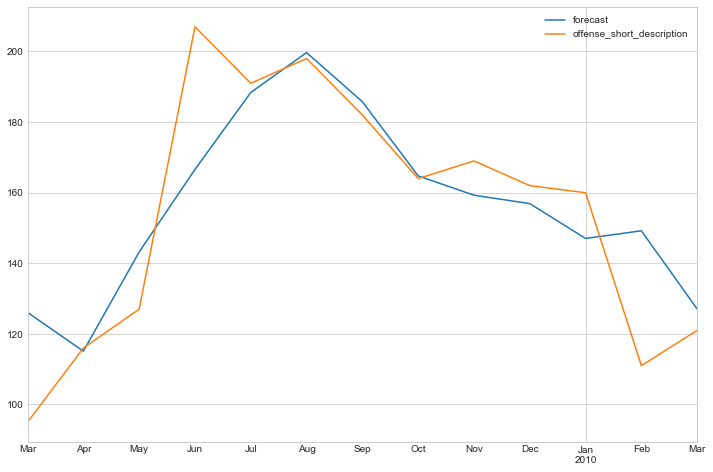

In [202]:
fig, ax = plt.subplots(figsize=(12, 8))
# ax = X[150:].plot(ax=ax)
fig = best.plot_predict(50, 62, dynamic=False, ax=ax)

Lets do a thought experiment where we train the model on some number of months TM and use it to predict forward for some number of months PM

In [185]:
print("length of time series {}".format(len(X)))

length of time series 161


In [186]:
TM = 12*5 #train months
PM = 12 #predict months

In [203]:
train_size = TM
predict_size = PM
train, test = X[0:train_size], X[train_size:train_size + predict_size]
# using the 12 month model
predicted = best.predict(train_size, train_size + predict_size, dynamic=False)

In [204]:
compare = pd.DataFrame(test)
compare.columns = ['actual']
compare['predicted'] = predicted
compare['difference'] = compare['actual'] - compare['predicted']
compare['percent error'] = (compare['difference']/compare['actual']) * 100.
print(compare)

             actual   predicted  difference  percent error
incident_dt                                               
2010-01-31      160  147.037152   12.962848       8.101780
2010-02-28      111  149.206127  -38.206127     -34.419934
2010-03-31      121  127.047637   -6.047637      -4.998047
2010-04-30      139  137.439420    1.560580       1.122719
2010-05-31      178  151.916626   26.083374      14.653581
2010-06-30      230  191.018244   38.981756      16.948590
2010-07-31      208  214.902972   -6.902972      -3.318737
2010-08-31      222  210.988075   11.011925       4.960327
2010-09-30      176  204.621289  -28.621289     -16.262096
2010-10-31      147  176.334448  -29.334448     -19.955407
2010-11-30      154  166.012274  -12.012274      -7.800178
2010-12-31      113  145.390128  -32.390128     -28.663830


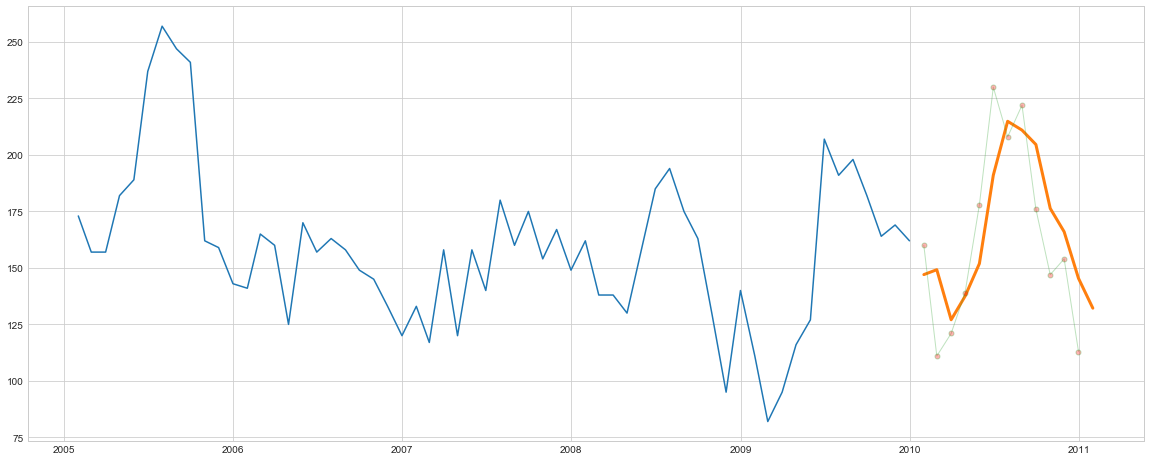

In [205]:
plt.plot(train)
plt.plot(predicted, lw=3.0)
plt.plot(test, '-o', ms=5, lw=1, alpha=0.3, mfc='red')

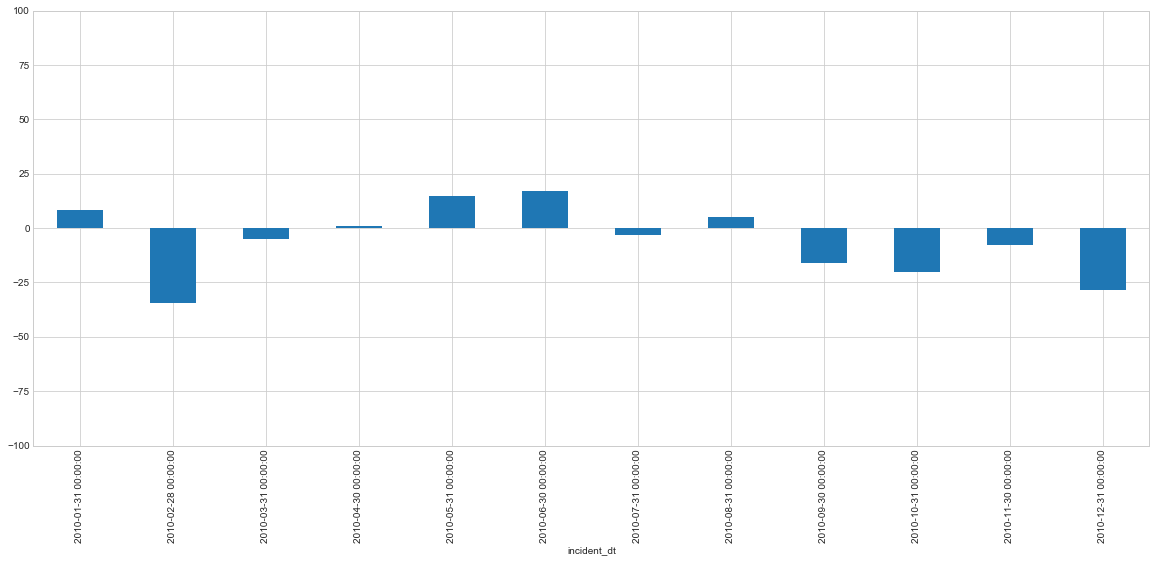

In [207]:
plt.ylim(-100,100)
compare['percent error'].plot(kind='bar')

### things to try next

#### simple forecasting

In [208]:
forecast, stderr, conf = best.forecast()

In [209]:
print(forecast,stderr,conf)

(array([ 166.89631742]), array([ 32.25722543]), array([[ 103.67331734,  230.1193175 ]]))


#### box-cox transform

The Box-Cox transform is a method that is able to evaluate a suite of power transforms, including, but not limited to, log, square root, and reciprocal transforms of the data. The example below performs a log transform of the data and generates some plots to review the effect on the time series.

#### rolling forecast validation

We can load the model and use it in a pretend operational manner. In the test harness section, we saved the final 12 months of the original dataset in a separate file to validate the final model. We can load this validation.csv file now and use it see how well our model really is on unseen data. There are two ways we might proceed:
􏰀 Load the model and use it to forecast the next 12 months. The forecast beyond the first one or two months will quickly start to degrade in skill.
􏰀 Load the model and use it in a rolling-forecast manner, updating the transform and model for each time step. This is the preferred method as it is how one would use this model in practice, as it would achieve the best performance.
As with model evaluation in previous sections, we will make predictions in a rolling-forecast manner. This means that we will step over lead times in the validation dataset and take the observations as an update to the history.